In [3]:
%matplotlib inline
import torch
import torchvision
import os
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

os.environ['TORCH_HOME'] = "checkpoints"

In [5]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [6]:
# 创建全卷积网络
net = nn.Sequential(*list(pretrained_net.children()))[:-2]

In [7]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape    # net前向传播会下采样32倍

torch.Size([1, 512, 10, 15])

In [8]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, 
                                                    kernel_size=64, padding=16, stride=32))

In [9]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """ 双线性插值 先不用懂 """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [10]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))  # 用双线性插值函数初始化转置卷积核

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [13]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('catdog.jpg'))   # CHW
print(f'img.shape {img.shape}')

X = img.unsqueeze(0)    # BCHW
print(f'升维 X.shape {X.shape}')

Y = conv_trans(X)       # BCHW HW均翻倍
print(f'转置卷积 Y.shape {Y.shape}')

out_img = Y[0].permute(1, 2, 0).detach()    # BHWC  将通道维放到最后，为了打印图像
print(f'通道维放到最后 out_img.shape {out_img.shape} Y.shape {Y.shape}')

img.shape torch.Size([3, 561, 728])
升维 X.shape torch.Size([1, 3, 561, 728])
转置卷积 Y.shape torch.Size([1, 3, 1122, 1456])
通道维放到最后 out_img.shape torch.Size([1122, 1456, 3]) Y.shape torch.Size([1, 3, 1122, 1456])


input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


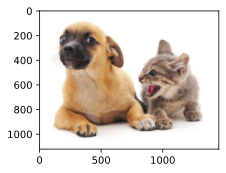

In [15]:
d2l.set_figsize()
print(f'input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))

print(f'output image shape:', out_img.shape)
d2l.plt.imshow(out_img)

In [17]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [18]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.498, train acc 0.850, test acc 0.852
130.3 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]


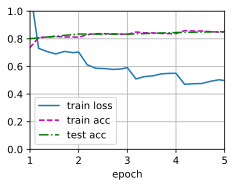

In [19]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, .001, 1e-3, d2l.try_all_gpus()
trainer =torch.optim.SGD(net.parameters(), lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [20]:
def predict(img):
    print(f'img.shape {img.shape}')
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    
    print(f'net(X.to(devices[0])) {net(X.to(devices[0])).shape}')
    pred = net(X.to(devices[0])).argmax(dim=1)
    print(f'pred.shape {pred.shape}')

    return pred.reshape(pred.shape[1], pred.shape[2])

In [21]:
def label2image(pred):
    """ 将预测类别映射到标记颜色 \n
        pred:预测的类别\n
        return:标记的类别颜色 """
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

img.shape torch.Size([3, 320, 480])
net(X.to(devices[0])) torch.Size([1, 21, 320, 480])
pred.shape torch.Size([1, 320, 480])
img.shape torch.Size([3, 320, 480])
net(X.to(devices[0])) torch.Size([1, 21, 320, 480])
pred.shape torch.Size([1, 320, 480])
img.shape torch.Size([3, 320, 480])
net(X.to(devices[0])) torch.Size([1, 21, 320, 480])
pred.shape torch.Size([1, 320, 480])
img.shape torch.Size([3, 320, 480])
net(X.to(devices[0])) torch.Size([1, 21, 320, 480])
pred.shape torch.Size([1, 320, 480])


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

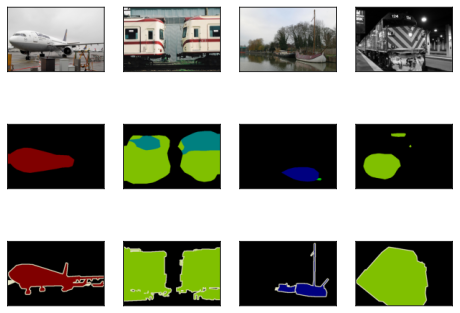

In [22]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)  # 裁剪区域
    pred = label2image(predict(X))      # 裁剪区域的预测结果
    imgs += [X.permute(1, 2, 0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect
             ).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)